## Data Preprocessing

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [2]:
print(tf.__version__)

2.6.0


### Get the dataset

In [3]:
training_dir = '../dataset/training'
validation_dir = '../dataset/validation'
test_dir = '../dataset/test'

BATCH_SIZE = 32
IMG_SIZE = (150, 150)

In [4]:
training_dataset = tf.keras.utils.image_dataset_from_directory(training_dir,
                                                               shuffle=True,
                                                               batch_size=BATCH_SIZE,
                                                               image_size=IMG_SIZE)

Found 13140 files belonging to 6 classes.


In [5]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2580 files belonging to 6 classes.


### Explore the training dataset
Here are the first nine images from the training dataset:

In [6]:
class_names = training_dataset.class_names
class_names

['building', 'forest', 'glacier', 'mountain', 'sea', 'street']

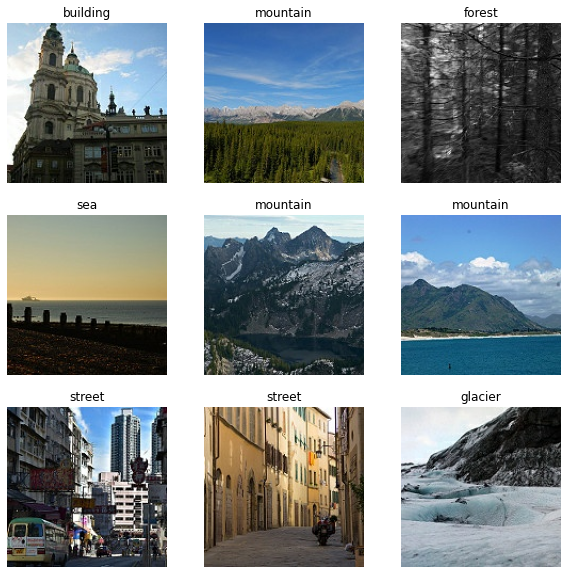

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in training_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Model Development And Training

### Data augmentation

In [8]:
IMG_SHAPE = IMG_SIZE + (3,)

data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal", input_shape=IMG_SHAPE),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

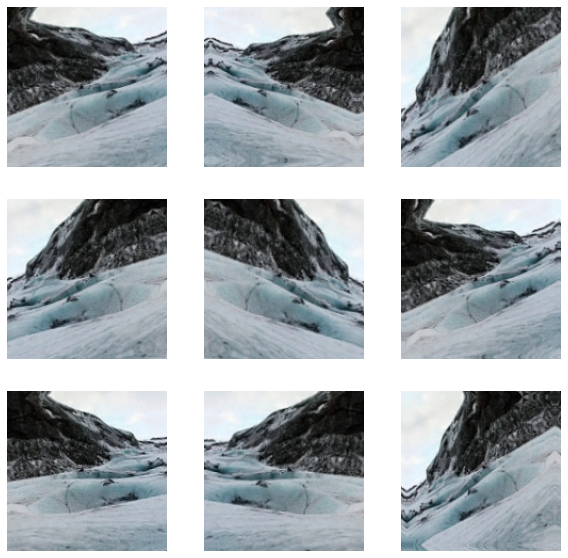

In [9]:
plt.figure(figsize=(10, 10))
for images, _ in training_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [10]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

## Compile and train the model

In [11]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)       

In [13]:
epochs = 30
model.fit(
  training_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/30
411/411 [==============================] - 95s 228ms/step - loss: 1.0541 - accuracy: 0.5906 - val_loss: 0.8481 - val_accuracy: 0.6953
Epoch 2/30
411/411 [==============================] - 95s 231ms/step - loss: 0.8172 - accuracy: 0.6947 - val_loss: 0.8062 - val_accuracy: 0.7097
Epoch 3/30
411/411 [==============================] - 95s 231ms/step - loss: 0.7156 - accuracy: 0.7362 - val_loss: 0.7282 - val_accuracy: 0.7391
Epoch 4/30
411/411 [==============================] - 94s 229ms/step - loss: 0.6561 - accuracy: 0.7629 - val_loss: 0.6834 - val_accuracy: 0.7574
Epoch 5/30
411/411 [==============================] - 96s 234ms/step - loss: 0.6113 - accuracy: 0.7762 - val_loss: 0.6248 - val_accuracy: 0.7612
Epoch 6/30
411/411 [==============================] - 91s 220ms/step - loss: 0.5764 - accuracy: 0.7876 - val_loss: 0.6883 - val_accuracy: 0.7609
Epoch 7/30
411/411 [==============================] - 90s 219ms/step - loss: 0.5379 - accuracy: 0.8014 - val_loss: 0.6467 - val_ac

## Prediction On New Data

Finally, let's use our model to classify images that were not included in the training or validation datasets.

In [14]:
import pathlib

dataset_dir = pathlib.Path('../dataset')

dataset_test_dir = list(dataset_dir.glob('test/*'))

In [15]:
for i in range(9):
    path_to_file = str(dataset_test_dir[i])
    img = tf.keras.utils.load_img(path_to_file, target_size=IMG_SHAPE)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    print("This image most likely belongs to {} with a {:.2f} percent confidence."
          .format(class_names[np.argmax(score)], 100 * np.max(score)))

This image most likely belongs to mountain with a 96.76 percent confidence.
This image most likely belongs to sea with a 96.35 percent confidence.
This image most likely belongs to mountain with a 84.14 percent confidence.
This image most likely belongs to forest with a 99.99 percent confidence.
This image most likely belongs to mountain with a 96.58 percent confidence.
This image most likely belongs to glacier with a 93.66 percent confidence.
This image most likely belongs to building with a 99.96 percent confidence.
This image most likely belongs to forest with a 98.89 percent confidence.
This image most likely belongs to building with a 56.80 percent confidence.


In [16]:
def make_predictions(index):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        path_to_file = str(dataset_test_dir[i + index])
        img = tf.keras.utils.load_img(path_to_file, target_size=(150, 150))
        img_array = tf.keras.utils.img_to_array(img)
        plt.imshow(img_array.astype("uint8"))
        img_array = tf.expand_dims(img_array, 0)
        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])
        plt.title(class_names[np.argmax(score)])
        plt.axis("off")

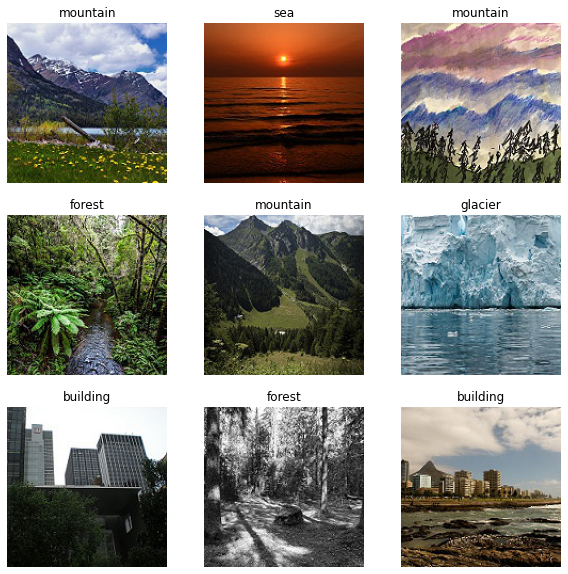

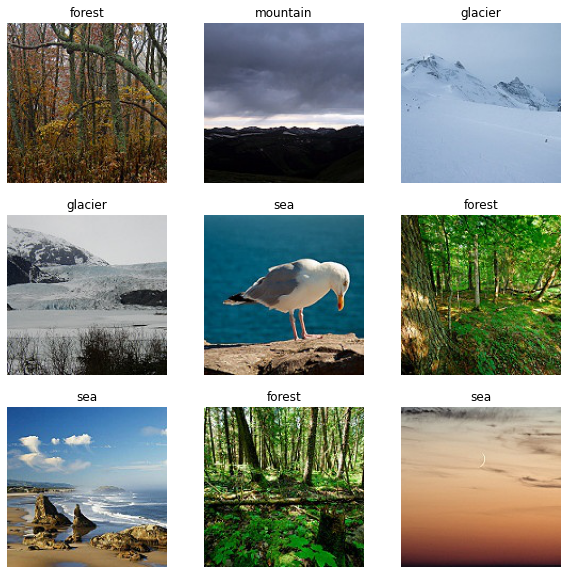

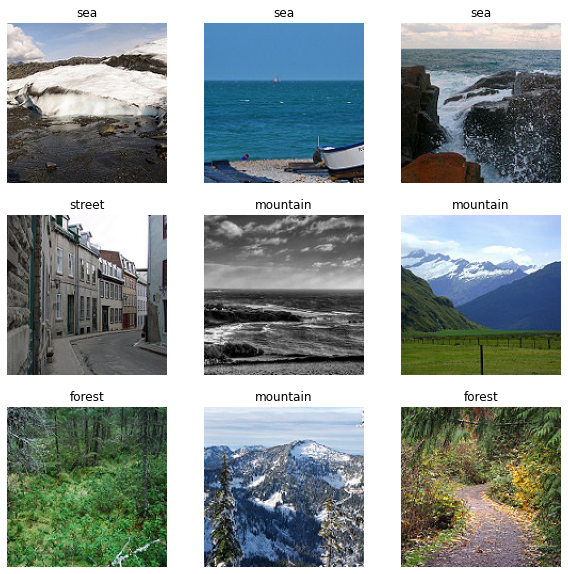

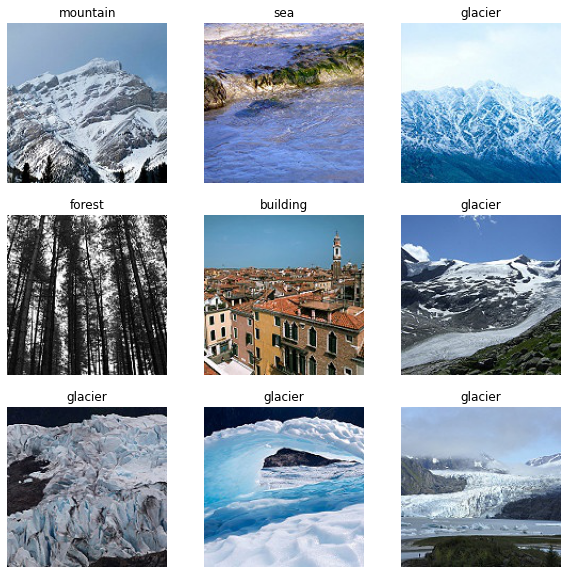

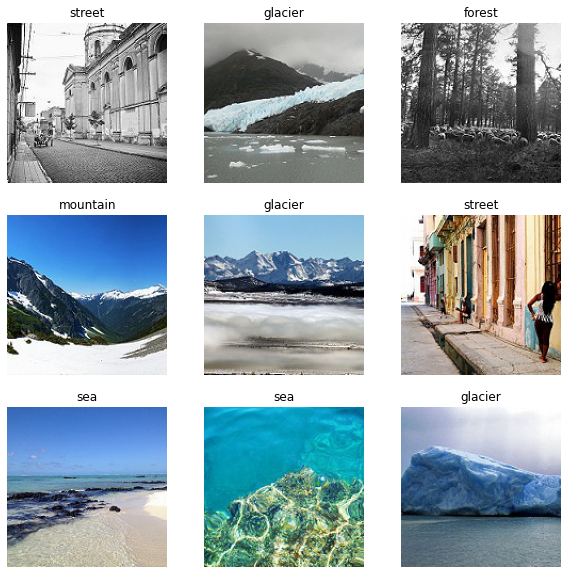

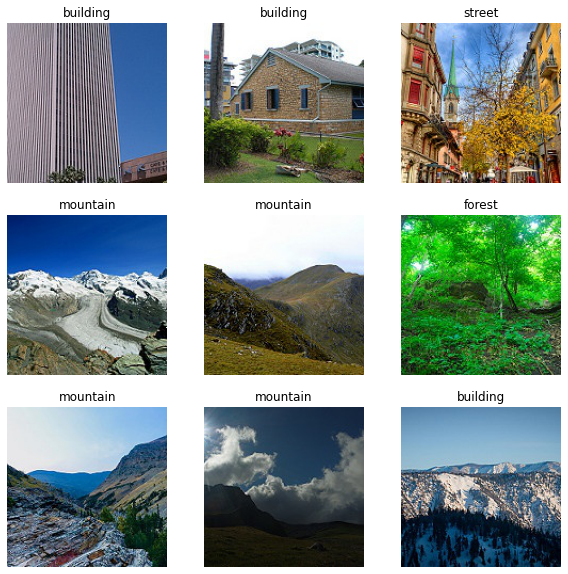

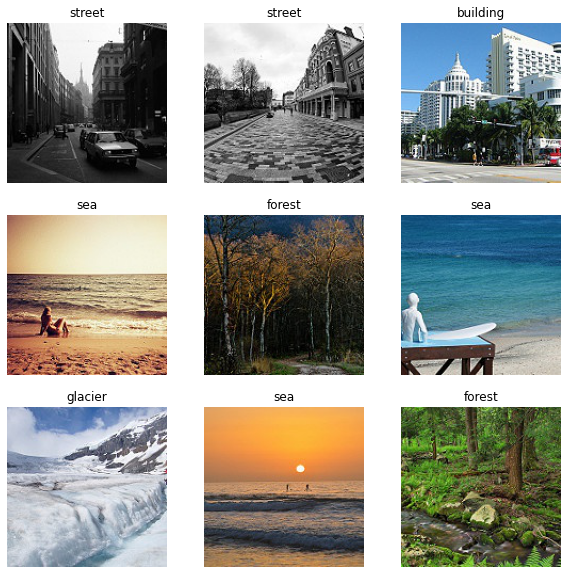

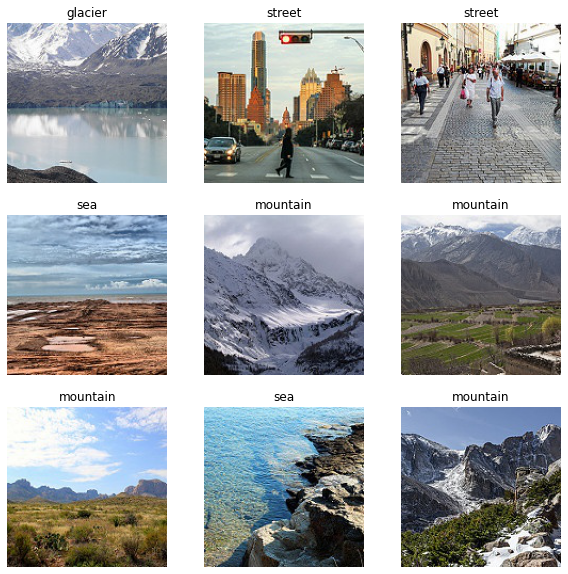

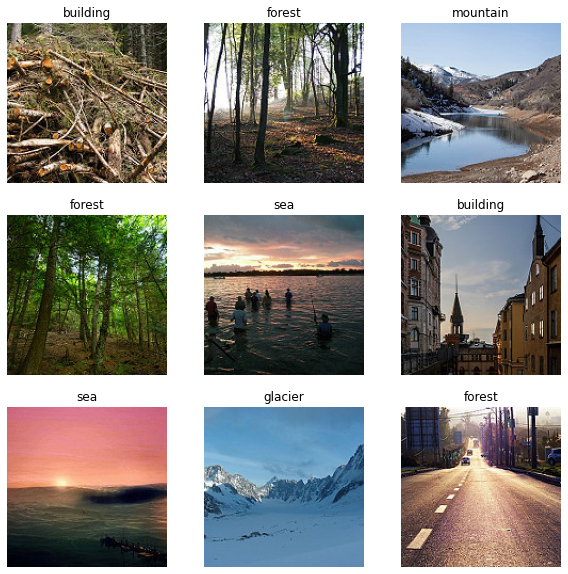

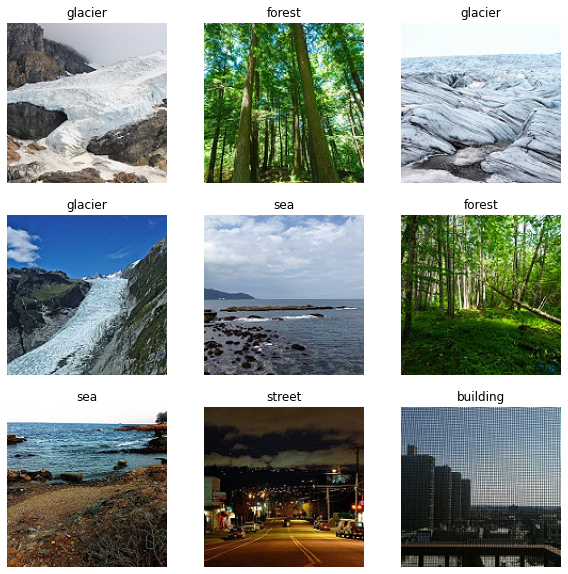

In [17]:
for i in range(0,90,9):
    make_predictions(i)

## Save the model 

In [18]:
model.save('../SavedModel/')

INFO:tensorflow:Assets written to: ../SavedModel/assets


In [19]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
with open('../TFLite/model.tflite', 'wb') as file:
    file.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\fagai\AppData\Local\Temp\tmpc7fxrhg0\assets
